<a href="https://colab.research.google.com/github/Navya-S/ERA_Session9/blob/main/session10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
import torch
import torch.nn as nn


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()

        self.resblock = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.resblock(x)


class CustomResnet(nn.Module):
    def __init__(self):
        super(CustomResnet, self).__init__()

        self.prep = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResBlock(channels=128),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            ResBlock(channels=512),
        )

        self.pool = nn.MaxPool2d(kernel_size=4)

        self.fc = nn.Linear(in_features=512, out_features=10, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        # x = self.softmax(x)
        return x

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
!pip install torchinfo
!pip install torch_lr_finder
import torch
import torchvision
from torchinfo import summary
from torch_lr_finder import LRFinder


def find_lr(model, optimizer, criterion, device, trainloader, numiter, startlr, endlr):
    lr_finder = LRFinder(
        model=model, optimizer=optimizer, criterion=criterion, device=device
    )

    lr_finder.range_test(
        train_loader=trainloader,
        start_lr=startlr,
        end_lr=endlr,
        num_iter=numiter,
        step_mode="exp",
    )

    lr_finder.plot()

    lr_finder.reset()


def one_cycle_lr(optimizer, maxlr, steps, epochs):
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=maxlr,
        steps_per_epoch=steps,
        epochs=epochs,
        pct_start=5 / epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy="linear",
    )
    return scheduler


def show_random_images_for_each_class(train_data, num_images_per_class=16):
    for c, cls in enumerate(train_data.classes):
        rand_targets = random.sample(
            [n for n, x in enumerate(train_data.targets) if x == c],
            k=num_images_per_class,
        )
        show_img_grid(np.transpose(train_data.data[rand_targets], axes=(0, 3, 1, 2)))
        plt.title(cls)


def show_img_grid(data):
    try:
        grid_img = torchvision.utils.make_grid(data.cpu().detach())
    except:
        data = torch.from_numpy(data)
        grid_img = torchvision.utils.make_grid(data)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))


def show_random_images(data_loader):
    data, target = next(iter(data_loader))
    show_img_grid(data)


def show_model_summary(model, batch_size):
    summary(
        model=model,
        input_size=(batch_size, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        verbose=1,
    )

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import torchvision
# from utils.transforms import train_transform, test_transform

from tqdm import tqdm
import torch
import torch.nn.functional as F


def train(
    model,
    device,
    train_loader,
    optimizer,
    criterion,
    L1=False,
    l1_lambda=0.01,
):
    model.train()
    pbar = tqdm(train_loader)

    train_losses = []
    train_acc = []

    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        if L1:
            l1_loss = 0
            for p in model.parameters():
                l1_loss = l1_loss + p.abs().sum()
            loss = loss + l1_lambda * l1_loss
        else:
            loss = loss

        train_loss += loss.item()
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f"Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )
        train_acc.append(100 * correct / processed)

    return train_losses, train_acc

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010),
            always_apply=True,
        ),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(
            min_holes=1,
            max_holes=1,
            min_height=8,
            min_width=8,
            max_height=8,
            max_width=8,
            fill_value=(0.4914, 0.4822, 0.4465),  # type: ignore
            p=0.5,
        ),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010),
            always_apply=True,
        ),
        ToTensorV2(),
    ]
)

def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    test_acc = 100.0 * correct / len(test_loader.dataset)

    return test_loss, test_acc



class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


train_dataset = Cifar10SearchDataset(
    root="./data", train=True, transform=train_transform
)

test_dataset = Cifar10SearchDataset(
    root="./data", train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# from models.custom_resnet import CustomResnet
# from utils.data import train_dataset, test_dataset
# from utils.training import train, test

# from utils.common import (
#     find_lr,
#     one_cycle_lr,
#     show_model_summary,
#     show_img_grid,
#     show_random_images,
#     show_random_images_for_each_class,
# )

### Create Dataloaders

In [6]:
batch_size = 512
shuffle = True
num_workers = 4

In [7]:
trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

testloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Check Sample Images

In [8]:
images, labels = next(iter(trainloader))

In [9]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(7))

In [10]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


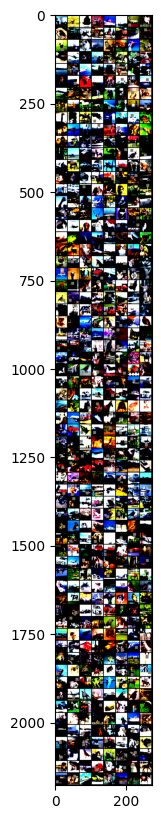

In [11]:
show_random_images(data_loader=trainloader)

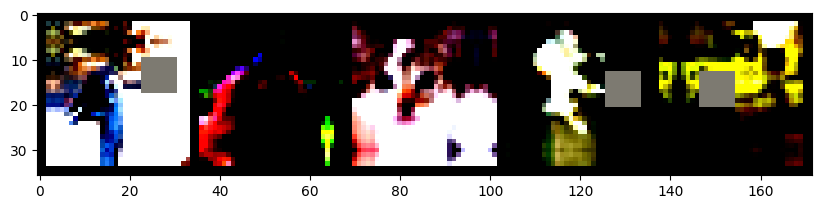

In [12]:
show_img_grid(images[25:30])

### Set Device

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
device

'cuda'

### Generate Model Summary

In [15]:
model = CustomResnet().to(device)

In [16]:
show_model_summary(model, batch_size)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CustomResnet                             [512, 3, 32, 32]          [512, 10]                 --                        --
├─Sequential: 1-1                        [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --
│    └─Conv2d: 2-1                       [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
│    └─ReLU: 2-3                         [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
├─Sequential: 1-2                        [512, 64, 32, 32]         [512, 128, 16, 16]        --                        --
│    └─Conv2d: 2-4                       [512, 64, 32, 32]         [512, 128, 32, 32]        73,728                    [3, 3]
│    └

### Declare Optimizer & Criterion

In [17]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

### Find LR

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.68E-02


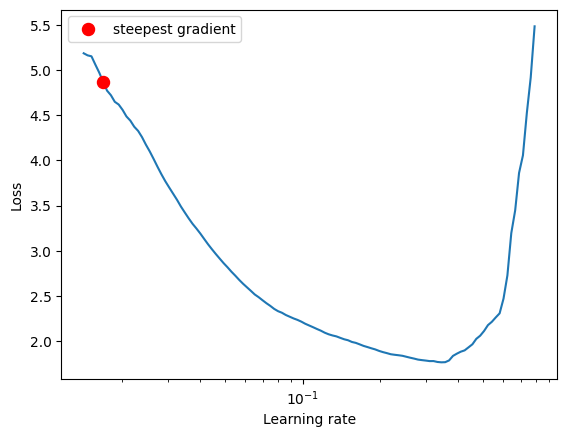

In [18]:
find_lr(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=trainloader,
    numiter=200,
    endlr=10,
    startlr=1e-2,
)

### Create the Scheduler - One Cycle Policy

In [21]:
epochs = 24
maxlr = 1.68E-02
scheduler = one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(trainloader), epochs=epochs
)

### Model Training & Evaluation

In [22]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc = train(
        model=model,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=trainloader,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test(
        model=model, device=device, criterion=criterion, test_loader=testloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    scheduler.step()

Epoch: 1


Loss=0.23574741184711456 Batch_id=97 Accuracy=90.13: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.3647, Accuracy: 8748/10000 (87.48%)

Epoch: 2


Loss=0.26236462593078613 Batch_id=97 Accuracy=90.96: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.4078, Accuracy: 8632/10000 (86.32%)

Epoch: 3


Loss=0.31250062584877014 Batch_id=97 Accuracy=91.30: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.3902, Accuracy: 8700/10000 (87.00%)

Epoch: 4


Loss=0.23048026859760284 Batch_id=97 Accuracy=91.30: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.3828, Accuracy: 8728/10000 (87.28%)

Epoch: 5


Loss=0.2855234742164612 Batch_id=97 Accuracy=91.57: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.3923, Accuracy: 8719/10000 (87.19%)

Epoch: 6


Loss=0.27479809522628784 Batch_id=97 Accuracy=91.75: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.3958, Accuracy: 8704/10000 (87.04%)

Epoch: 7


Loss=0.2678414583206177 Batch_id=97 Accuracy=91.77: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4003, Accuracy: 8697/10000 (86.97%)

Epoch: 8


Loss=0.24252565205097198 Batch_id=97 Accuracy=91.77: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.4305, Accuracy: 8598/10000 (85.98%)

Epoch: 9


Loss=0.23340065777301788 Batch_id=97 Accuracy=91.73: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.4218, Accuracy: 8599/10000 (85.99%)

Epoch: 10


Loss=0.24437159299850464 Batch_id=97 Accuracy=92.25: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.3968, Accuracy: 8729/10000 (87.29%)

Epoch: 11


Loss=0.22174127399921417 Batch_id=97 Accuracy=92.51: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.3610, Accuracy: 8820/10000 (88.20%)

Epoch: 12


Loss=0.19106653332710266 Batch_id=97 Accuracy=92.67: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.3763, Accuracy: 8816/10000 (88.16%)

Epoch: 13


Loss=0.2077145278453827 Batch_id=97 Accuracy=92.90: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.5350, Accuracy: 8401/10000 (84.01%)

Epoch: 14


Loss=0.21235391497612 Batch_id=97 Accuracy=92.93: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.3733, Accuracy: 8798/10000 (87.98%)

Epoch: 15


Loss=0.18508833646774292 Batch_id=97 Accuracy=93.27: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.4071, Accuracy: 8716/10000 (87.16%)

Epoch: 16


Loss=0.24396666884422302 Batch_id=97 Accuracy=93.37: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.4080, Accuracy: 8747/10000 (87.47%)

Epoch: 17


Loss=0.1461029350757599 Batch_id=97 Accuracy=93.66: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.3574, Accuracy: 8899/10000 (88.99%)

Epoch: 18


Loss=0.19587039947509766 Batch_id=97 Accuracy=93.93: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.3626, Accuracy: 8882/10000 (88.82%)

Epoch: 19


Loss=0.20612618327140808 Batch_id=97 Accuracy=94.24: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set: Average loss: 0.3424, Accuracy: 8925/10000 (89.25%)

Epoch: 20


Loss=0.13733622431755066 Batch_id=97 Accuracy=94.38: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4177, Accuracy: 8741/10000 (87.41%)

Epoch: 21


Loss=0.12668004631996155 Batch_id=97 Accuracy=94.32: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.3677, Accuracy: 8878/10000 (88.78%)

Epoch: 22


Loss=0.1797272115945816 Batch_id=97 Accuracy=94.36: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.3902, Accuracy: 8780/10000 (87.80%)

Epoch: 23


Loss=0.18389950692653656 Batch_id=97 Accuracy=94.43: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4215, Accuracy: 8742/10000 (87.42%)

Epoch: 24


Loss=0.08100418001413345 Batch_id=97 Accuracy=94.55: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4127, Accuracy: 8802/10000 (88.02%)



In [25]:
import matplotlib.pyplot as plt

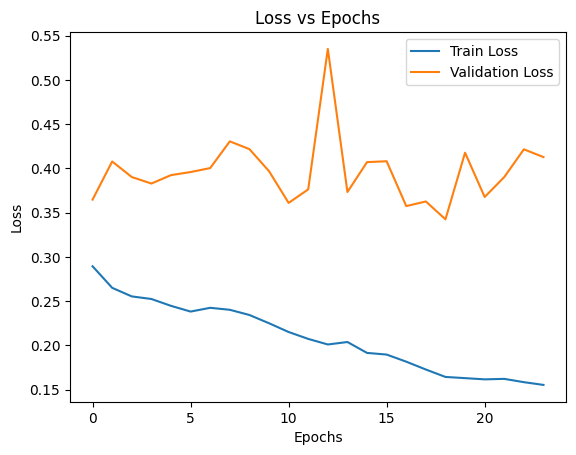

In [23]:
plt.plot(range(epochs), results["trainloss"])
plt.plot(range(epochs), results["testloss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

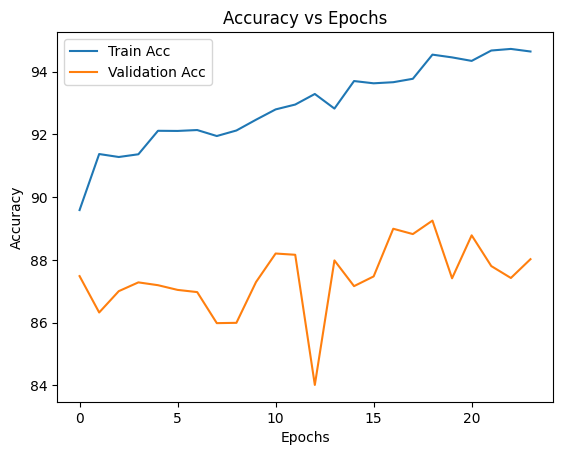

In [24]:
plt.plot(range(epochs), results["trainacc"])
plt.plot(range(epochs), results["testacc"])
plt.legend(["Train Acc", "Validation Acc"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()